# Extended Data Fig. 9
- This notebook analyze the short habenula recordings peformed to determine the habenula laterality.

In [1]:
# import packages
from utility import *
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import flammkuchen as fl
import json
import colorcet as cc
from tqdm import tqdm

C:\Users\ryosuke\miniconda3\envs\hd_pub\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ryosuke\miniconda3\envs\hd_pub\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\ryosuke\miniconda3\envs\hd_pub\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# config matplotlib
config_rcparams()

In [8]:
# parameters
corr_thresh = 0.3
mask_name= 'habenula'

In [5]:
# find habenula recordings
fish_list = list(Path('../data/main05').iterdir())
rec_list = [fish / 'habenula' for fish in fish_list]

# Analysis
## Data loading and ROI selection

In [9]:
# Loop through all fish
data = []

for fish in tqdm(rec_list):

    # load scan metadata (to get the scale for anatomy visualization)
    with open(fish / 'scandata.json', 'r') as f:
        zoom = json.load(f)['magnification']
    
    # Load data
    s2p_data, t_i, exp = load_data(fish, cells_only=False)

    # Load mask
    mask_list = list(fish.glob('mask_'+mask_name+'*'))
    with open(mask_list[-1], 'r') as f:
        mask = json.load(f)

    # Pull out arrays from data structure so it is easier to handle
    stack      = s2p_data['anatomy_stack'][0,:,:] # assuming planar scanning
    roi_coords = s2p_data['coords']
    traces     = s2p_data['traces'][:,:len(t_i)]
    norm_traces = ((traces.T - np.median(traces, axis=1))/np.std(traces, axis=1)).T
    n_roi = traces.shape[0]

    # behavioral / stimulus data
    slog = exp['stimulus']['log']
    
    # Calculate correlation
    flash_duration = slog[1]['duration']*2
    flash_t_start = [epoch['t_start'] for epoch in slog[1:-1:2]] # first epoch is wait 
    flash_corr = calc_snip_correlation(norm_traces, t_i, flash_t_start, flash_duration)
    consistent = flash_corr > corr_thresh
    
    # Calculate mean response, just so we can tell ON and OFF cells
    f_snip, t_snip = cut_snip(traces, t_i, flash_t_start, 0, flash_duration, subtract_pre=0)
    on_resp = np.mean(f_snip[:, :, t_snip<flash_duration/2], axis=(0,2))
    off_resp = np.mean(f_snip[:, :, t_snip>=flash_duration/2], axis=(0,2))
    diff_resp = on_resp - off_resp
    
    # anatomical selection
    in_mask = (roi_coords[:,2]>mask['x0'])*(roi_coords[:,2]<mask['x1'])*\
              (roi_coords[:,1]>mask['y0'])*(roi_coords[:,1]<mask['y1'])
    roix = stack.shape[0] - roi_coords[:,1]
    roiy = stack.shape[1] - roi_coords[:,2]

    # Categorize ROIs as being on the left or right
    midline = (mask['y0']+mask['y1'])/2
    n_l_viscell = np.sum(consistent*in_mask*(roix<midline))
    n_r_viscell = np.sum(consistent*in_mask*(roix>midline))
    if n_l_viscell >= n_r_viscell:
        label = 'situs solitus'
    else:
        label = 'situs invertus'
        
    # Store data to a library
    D = {
        'x': roix,
        'y': roiy,
        'corr': flash_corr,
        'diff_resp': diff_resp,
        'stack': np.fliplr(np.rot90(stack)),
        'in_mask': in_mask,
        'consistent': consistent,
        'label': label,
        'n_viscell': (n_l_viscell, n_r_viscell),
        'zoom': zoom
        }
    data.append(D)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:03<00:00,  9.82it/s]


# Panels
## Extended Data Fig. 9b (individual examples of fish with typical and inverted habenula)

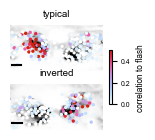

In [10]:
# show one example each of situs solitus and inversus
fids = (12, 18)

fig, ax = plt.subplots(len(fids), 1, figsize=(1.5, 0.7*len(fids)))
for fid, axx, lat in zip(fids, ax, ('typical', 'inverted')):
    D = data[fid]
    scaled_imshow(D['stack'], ax=axx, cmap='gray_r')
    # scale bar
    um_per_px = 500 / D['zoom'] / D['stack'].shape[0]
    axx.plot((110, 110+10/um_per_px), (300,300), lw=1.5, color='black')
    
    axx.set_ylim([330, 120])
    axx.set_xlim([100, 520])
    sc = axx.scatter(D['x'][D['in_mask']], D['y'][D['in_mask']], s=2, c=D['corr'][D['in_mask']],
                vmin=0, vmax=0.5, cmap=cc.cm.CET_L19)
    axx.axis('off')
    axx.set_title(lat)
    
cb = plt.colorbar(sc, location='right', ax=ax, shrink=0.5)
cb.set_label('correlation to flash')

plt.savefig('../svg/ed09_b.svg')
plt.show()

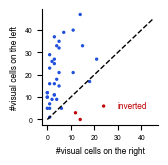

In [7]:
n_viscell = np.asarray([D['n_viscell'] for D in data])
fig, ax = plt.subplots(1, 1, figsize=(1.5, 1.5))
ax.scatter(n_viscell[:,1], n_viscell[:,0], c=(np.diff(n_viscell,axis=1)>2), cmap=cc.cm.CET_D1, s=2)
ax.plot([0,45],[0,45],'k--')
ax.text(30, 5, 'inverted', color=cc.cm.CET_D1(1.0))
ax.set_xlabel('#visual cells on the right')
ax.set_ylabel('#visual cells on the left')
toggle_spines(ax, 0, 1, 0, 1)

plt.savefig('./png/007_002.png')
plt.savefig('./svg/007_002.svg')
plt.show()

## Visualize anatomy stack before and after ablation

In [27]:
## Load data
pre_stack_name = r'Z:\Ryosuke\E0084_v06b_ablation_batch2\20241112_f1\20241112_f1_pre_v99\zstack\zstack_153950'
post_stack_name = r'Z:\Ryosuke\E0084_v06b_ablation_batch2\20241112_f1\20241112_f1_pre_v99\zstack\zstack_155037'
next_day_stack_name = r'Z:\Ryosuke\E0084_v06b_ablation_batch2\20241112_f1\20241112_f1_pre_v99\zstack\zstack_111640'

stack_names = (pre_stack_name, post_stack_name, next_day_stack_name)
stacks = []
mags = []
z_thickness = []

# loop through the files
for name in stack_names:
    # load stacks
    stacks.append(fl.load(name+'.h5')['stack_4D'][0, :, :, :])
    # load magnifications (they are the same, but just to make sure...)
    with open(name + '_scandata.json') as f:
        scandata = json.load(f)
        mags.append(scandata['magnification'])
        z_thickness.append(scandata['_zstack_thickness'])



In [30]:
print(mags)
print(z_thickness)
nominal_image_width = 500 / mags[0]
micron_per_px = nominal_image_width / stacks[0].shape[2]
print(micron_per_px)

[7.0, 7.0, 7.0]
[1.0, 1.0, 1.0]
0.14547570555717196


In [35]:
def rotinv(im):
    return np.rot90(np.flipud(im))

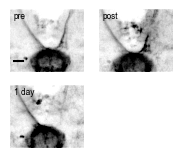

In [84]:
fig, ax = plt.subplots(2, 2, figsize=(2.1,1.8))
k=0
labels = ('pre', 'post', '1 day')
for stack in stacks:
    scaled_imshow(rotinv(np.percentile(stack[:100,:,:], 95, axis=0))[:, 30:], cmap='gray_r', ax=ax[k//2, k%2], levelrange=(10,95))
    ax[k//2, k%2].text(30, 70, labels[k])
    k+=1
ax[0,0].plot((30 + 0, 30 + 10/micron_per_px),(400, 400), lw=1.5, color='black')
for axx in ax:
    for axxx in axx:
        axxx.axis('off')

plt.savefig('./png/007_003.png')
plt.savefig('./svg/007_003.svg')
plt.show()